This is a version for the file generated for the Ca1 recording that I made: http://localhost:8888/lab/tree/repo/autopi_analysis/maryam/Figs/LeverTime_final.ipynb

We first get the Reslever Press and then get the cross correlation of the cell and the mrate, if the peak of the firing rate was above zero means they fire after the lever press if it was before mean it happend before the lever press

## Get the lever press time for one session and then apply it for all sessions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run ../setup_project.py
%run ../generic_plot_functions.py
import os.path
from spikeA.Dat_file_reader import Dat_file_reader
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy import integrate
from scipy.ndimage import gaussian_filter1d 
import os

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [2]:
prepareSessionsForSpatialAnalysisProject(sSessions,myProject.sessionList) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|████████████████████████████████████████████████████████████████| 180/180 [06:07<00:00,  2.04s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


## from now only use the df called 'cells_with_leverCells.csv'

In [3]:
%%time
fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

fn = myProject.dataPath+"/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myMaps = pickle.load(handle)
    
fn = "/adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    print('loading',fn)
    myLeverMaps = pickle.load(handle)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading /adata/projects/autopi_inter//results/myMaps.pickle
loading /adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle
loading behavior_180_v2.csv
CPU times: user 175 ms, sys: 6.48 s, total: 6.65 s
Wall time: 29.5 s


1. need to show that they have a higher vector length in the Lever reference frame than in the cardinal reference frame.
2. You need to show that these cells are not simply cells with a lever-anchored field. Maybe comparing lever and cardinal reference frames is the easiest way.
  

## get the cross correlation with the lever press for one session

In [4]:
def get_LeverCrossCorr(ses,sSes,res, bin_size_sec= 0.05 , min_sec= -1 , max_sec=1 ):
    
    ### first get the res time of the lever press
    
    LeverPressinRestime= res[res.sessionName== sSes.name].levertimeRes.values
    
    ### now get the cross_corr
    histStack=[]
    timestampStack=[]
    mRate=[]
    for i, n in enumerate(sSes.cg.neuron_list):
        rate= n.spike_train.mean_firing_rate()
        hist,ran= n.spike_train.spike_time_crosscorrelation(st1= LeverPressinRestime, st2=n.spike_train.st , 
                                                            bin_size_sec= bin_size_sec , min_sec= min_sec , max_sec=max_sec )
        timestamp = n.spike_train.mid_point_from_edges(ran)
        histStack.append(hist)
        timestampStack.append(ran)
        mRate.append(rate)
    
    histStack= np.stack(histStack,axis=0)
    timestampStack= np.stack(timestampStack, axis=0)
    mRate= np.stack(mRate, axis=0)
    return histStack, timestampStack , mRate 

## Try the func on one session 

In [5]:
sSes= sSessions[136]
ses= myProject.sessionList[136]
histStack, timestampStack , mRate = get_LeverCrossCorr(ses,sSes, res, bin_size_sec= 0.02 , min_sec= -1 , max_sec=1 )
timestampStack= timestampStack[:,:-1]

In [6]:
timestampStack.shape, len(sSes.cg.neuron_list), histStack.shape, mRate.shape 

((185, 100), 185, (185, 100), (185,))

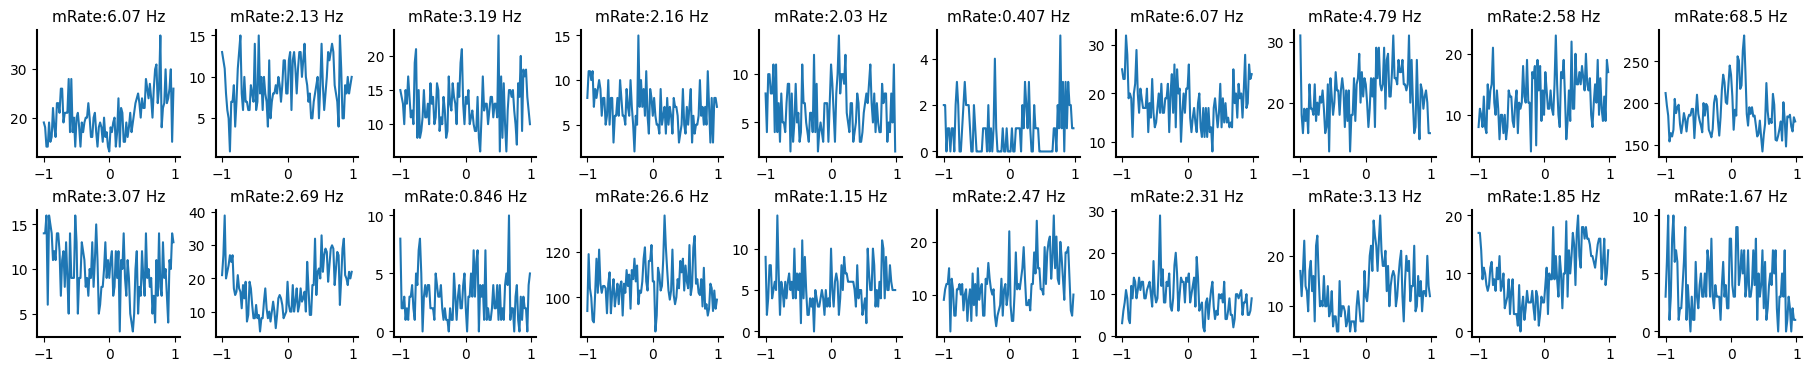

In [7]:
row=2
col=10

sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig) # all our figure

for i, ind in enumerate(sSes.cg.neuron_list[:20]):
    ax = fig.add_subplot(gs[i])
    ax.plot(timestampStack[i], histStack[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.set_title("mRate:{:.3} Hz".format(mRate[i]), fontsize= 11)
    
  

## get the crossCorr of the cells with the lever for all sessions 

In [33]:
histSt, timeSt, rateSt = [], [], []

for sSes, ses in tqdm(zip(sSessions, myProject.sessionList)):
    
    ###############
    ## Calculate the lever cross correlation 
    ###############
    histStack, timestampStack,mRateStack = get_LeverCrossCorr(ses,sSes, res, bin_size_sec= 0.02 , min_sec= -1 , max_sec=1)
    histSt.append(histStack)
    timeSt.append(timestampStack)
    rateSt.append(mRateStack)
    
histStack= np.vstack(histSt)
timeStack= np.vstack(timeSt)
rateStack= np.hstack(rateSt)

180it [00:02, 83.66it/s]


In [34]:
histStack.shape, timeStack.shape, rateStack.shape, np.vstack(histSt).shape, cells.shape

((10850, 100), (10850, 101), (10850,), (10850, 100), (10850, 41))

Save the output in a seperated folder

In [22]:
fn=myProject.dataPath + 'results/leverTime'
np.save(fn+ "histStack.npy",histStack)
np.save(fn+ "timeStack.npy",timeStack)
np.save(fn+ "rateStack.npy",rateStack)


In [23]:
## load the files 

fn=myProject.dataPath + 'results/leverTime'
histStack= np.load(fn+ "histStack.npy")
timeStack= np.load(fn+ "timeStack.npy")
rateStack= np.load(fn+ "rateStack.npy")
timeStack= timeStack[:,:-1]

In [26]:
#levercDid== levercLid

In [14]:
## get the cells that are lever cells in dark and light 
levercD= cells[(cells.usable_auto_RF) & (cells.leverCell_all_dark)]
levercL= cells[(cells.usable_auto_RF) & (cells.leverCell_all_light)]
Fs= cells[(cells.usable_auto_RF) & (cells.interneuron) & (cells.mrate_RF1>10)]
FsleverDid= list(cells[(cells.leverCell_all_dark) & (cells.usable_auto_RF) & (cells.interneuron) & (cells.mrate_RF1>10)].cluId)
gcleverDid= list(cells[(cells.leverCell_all_dark) & (cells.usable_auto_RF) & (cells.gridCell_FIRST)].cluId)

levercDid= list(cells[(cells.leverCell_all_dark) & (cells.usable_auto_RF) ].cluId)
levercLid= list(cells[(cells.leverCell_all_light) & (cells.usable_auto_RF) ].cluId)
FsleverLid= list(cells[(cells.leverCell_all_light) & (cells.usable_auto_RF) & (cells.interneuron) & (cells.mrate_RF1>10)].cluId)
gcleverLid= list(cells[(cells.leverCell_all_light) & (cells.usable_auto_RF) & (cells.gridCell_FIRST)].cluId)


In [15]:
#len()
len(levercD[levercD['leverCell_all_dark']].cluId.unique())

2069

In [16]:
len(cells[(cells.leverCell_all_dark) & (cells.usable_auto_RF) & (cells.gridCell_FIRST) ].cluId)

533

In [18]:
cells[(cells.usable_auto_RF) & (cells.leverCell_all_light)].index.values

array([   11,    19,    27, ..., 10844, 10846, 10848])

get the levercell indx for FS in light and dark index

In [19]:
## get the levercell index for light and dark 
lcD= cells.loc[cells.loc[:,'cluId'].isin(levercDid)] ## get the df for the leverCells
lcdInd= lcD.leverCell_all_dark.index.values.astype(int)

lcL= cells.loc[cells.loc[:,'cluId'].isin(levercLid)] ## get the df for the leverCells
lclInd= lcL.leverCell_all_light.index.values.astype(int)

## get the levercell in for fs 
FSleverD= cells.loc[cells.loc[:,'cluId'].isin(FsleverDid)] ## get the df for the leverCells
FSleverDInd= FSleverD.leverCell_all_dark.index.values.astype(int)

FSleverL= cells.loc[cells.loc[:,'cluId'].isin(FsleverLid)] ## get the df for the leverCells
FSleverLInd= FSleverL.leverCell_all_light.index.values.astype(int)

## get the levercell indx for gridcells
gcleverD= cells.loc[cells.loc[:,'cluId'].isin(gcleverDid)] ## get the df for the leverCells
gcleverDInd= gcleverD.leverCell_all_dark.index.values.astype(int)

gcleverL= cells.loc[cells.loc[:,'cluId'].isin(gcleverLid)] ## get the df for the leverCells
gcleverLInd= gcleverL.leverCell_all_light.index.values.astype(int)

### other type of the cells Others 
Dids= [gcleverDid, FsleverDid]
OthleverD = lcD.loc[~lcD['cluId'].isin(Dids)]
OthleverDInd= OthleverD.leverCell_all_dark.index.values.astype(int)

Lids= [gcleverLid, FsleverLid]
OthleverL = lcL.loc[~lcL['cluId'].isin(Lids)]
OthleverLInd= OthleverL.leverCell_all_light.index.values.astype(int)


In [20]:
lclInd, lcdInd

(array([   11,    19,    27, ..., 10844, 10846, 10848]),
 array([   11,    19,    27, ..., 10841, 10843, 10844]))

In [21]:
def element_wise_comparison(l1, l2):
    if len(l1) != len(l2):
        return False
    return all(x == y for x, y in zip(l1, l2))

In [22]:
print(element_wise_comparison(lclInd, lcdInd))  # False

False


## Get the percentage of each cell type for the lever cells (grid, FS, other cells)


In [23]:
def plot_levercellPercentage(gs,lcdInd, gcleverDInd,FSleverDInd, OthleverDInd, title= 'Lever cells in dark'):
    
    ax= fig.add_subplot(gs[0])
    lc_dark= lcdInd.shape[0]
    Othlc_dark= OthleverDInd.shape[0]
    glc_dark= gcleverDInd.shape[0]
    FSlc_dark= FSleverDInd.shape[0]
    
    levergcdP= (glc_dark / lc_dark) * 100
    leverfsdP= (FSlc_dark/ lc_dark) * 100
    leverOthdP= (Othlc_dark/ lc_dark)* 100

    Dperc = [levergcdP, leverfsdP, leverOthdP]
    Dlabel= ['gc:{}'.format(glc_dark), 'fs: {}'.format(FSlc_dark), 'others:{}'.format(Othlc_dark)]
    colors = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[3]]
    explode = (0.1, 0, 0.1)

    ax.pie(Dperc, explode=explode, labels= Dlabel,autopct='%1.1f%%', startangle=140)
    ax.set_title(title, fontsize=10)
    ax.axis('equal')

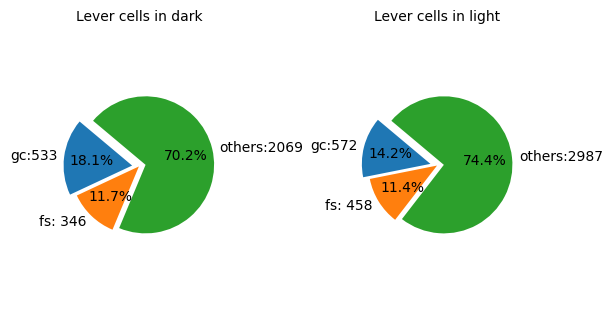

In [24]:
rowSize, colSize = 3, 3
col, row = 2, 1

fig = plt.figure(figsize=(col * colSize, row * rowSize), constrained_layout=True)  # create a figure
gs = fig.add_gridspec(ncols=col, nrows=row, hspace=0.2)  # create a GridSpec object to a figure

### dark
gsd= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[0])
plot_levercellPercentage(gsd,lcdInd, gcleverDInd,FSleverDInd, OthleverDInd, title= 'Lever cells in dark')

## light
gsl= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[1])
plot_levercellPercentage(gsl,lclInd, gcleverLInd,FSleverLInd, OthleverLInd, title= 'Lever cells in light')


# order the cells based on the best leverdirection selective cells and select the first 20  

In [25]:
from scipy import stats

fn=myProject.dataPath+"/results/atLever18/myLeverMapsHDInfo.pickle"
with open(fn, 'rb') as handle:
    HDInfo = pickle.load(handle)
    
fn=myProject.dataPath+"/results/atLever18/myLeverMapsHDInfoShuffle100.pickle"
with open(fn, 'rb') as handle:
    HDInfoShuffle100 = pickle.load(handle)

df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()

for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=HDInfo['Info'][light]
    df['HD_score']=HDInfo['HD'][light][:,2]
    df['HD_peakrate']=HDInfo['HD'][light][:,4]
    df['cluid'] = HDInfo['cluid'][light]
    df['Info_pc']=[stats.percentileofscore(HDInfoShuffle100['Info'][light][i,:], HDInfo['Info'][light][i], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['HD_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_mvl'][light][i,:], HDInfo['HD'][light][i,2], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['peak_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_peak'][light][i,:], HDInfo['HD'][light][i,4], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['light']=light
    df['shuffle']=False
df_HDInfoSingle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()
for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
    df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
    df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
    df['cluid'] = HDInfo['cluid'][light]
    df['light']=light
    df['shuffle']=True
    
df_HDInfoShuffle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo=pd.concat([df_HDInfoSingle,df_HDInfoShuffle])
df_HDInfo['sessionName'] = df_HDInfo['cluid'].apply(lambda x: x.split('_')[0])
df_HDInfo['mouse']= df_HDInfo['sessionName'].apply(lambda x: x.split('-')[0])


/tmp/ipykernel_722039/1970445736.py:27: RuntimeWarning: Mean of empty slice
  df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
/tmp/ipykernel_722039/1970445736.py:28: RuntimeWarning: Mean of empty slice
  df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
/tmp/ipykernel_722039/1970445736.py:29: RuntimeWarning: Mean of empty slice
  df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
/tmp/ipykernel_722039/1970445736.py:27: RuntimeWarning: Mean of empty slice
  df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
/tmp/ipykernel_722039/1970445736.py:28: RuntimeWarning: Mean of empty slice
  df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
/tmp/ipykernel_722039/1970445736.py:29: RuntimeWarning: Mean of empty slice
  df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)


In [26]:
df_HDInfo

,Info_score,HD_score,HD_peakrate,cluid,Info_pc,HD_pc,peak_pc,light,shuffle,sessionName,mouse
0,0.279404,0.048922,43.027336,mn8578-30112021-0107_20,55.0,99.0,100.0,all_light,False,mn8578-30112021-0107,mn8578
1,1.082781,0.070286,20.457983,mn8578-30112021-0107_22,93.0,72.0,90.0,all_light,False,mn8578-30112021-0107,mn8578
2,8.121414,1.000000,0.154065,mn8578-30112021-0107_45,68.0,NaN,NaN,all_light,False,mn8578-30112021-0107,mn8578
3,6.114751,0.607692,1.386587,mn8578-30112021-0107_48,93.0,86.0,39.0,all_light,False,mn8578-30112021-0107,mn8578
4,2.562055,0.230660,5.284979,mn8578-30112021-0107_57,99.0,99.0,92.0,all_light,False,mn8578-30112021-0107,mn8578
...,...,...,...,...,...,...,...,...,...,...,...
10845,2.311928,0.068612,2.079281,jp499-25052023-0108_523,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10846,0.529832,0.021795,13.795510,jp499-25052023-0108_528,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10847,0.354532,0.029990,26.930284,jp499-25052023-0108_530,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499
10848,0.834945,0.032977,9.343072,jp499-25052023-0108_533,NaN,NaN,NaN,all_dark,True,jp499-25052023-0108,jp499


## Select the first40 FS that have the most HD score (are directional selecive aroun dthe lever)

In [27]:
df_HDInfo_sorted = df_HDInfo[(df_HDInfo.shuffle== False) & (df_HDInfo.light== 'all_dark')].sort_values(by='HD_score', ascending=False)
cells_to_plot= list(df_HDInfo_sorted[df_HDInfo_sorted.cluid.isin(FsleverDid)].cluid.iloc[:40]) ## FS in dark being lever cells 
cells_to_plotind= cells[cells.cluId.isin(cells_to_plot)].interneuron.index.values.astype(int)

In [28]:
cells_to_plotind

array([  215,   326,   359,   425,   499,   529,   536,   576,   957,
         987,  1016,  1037,  1138,  1161,  1843,  2479,  2539,  3816,
        3831,  3883,  4405,  5001,  6859,  7433,  7496,  7640,  7725,
        7828,  8319,  8372,  8901,  9069,  9623,  9807,  9849,  9933,
       10445, 10446, 10557, 10781])

In [29]:
histStack.shape, timeStack.shape, timeStack[:,:-1].shape, rateStack.shape, cells.shape

((10850, 100), (10850, 101), (10850, 100), (10850,), (10850, 41))

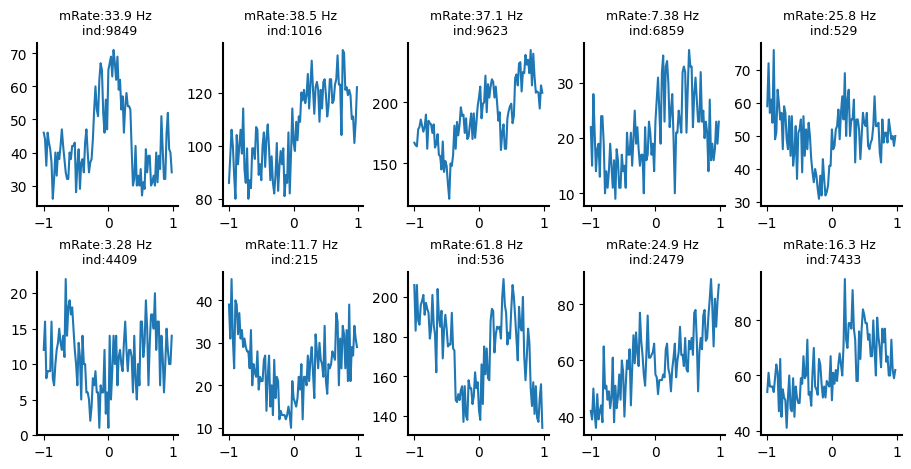

In [35]:
row=8
col=5
timeStack = timeStack[:,:-1]
sizePerRow, sizePerCol = figurePanelDefaultSize()
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig) # all our figure

for i, ind in enumerate(cells_to_plotind):
    ax = fig.add_subplot(gs[i])
    ax.plot(timeStack[ind], histStack[ind])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.set_title("mRate:{:.3} Hz \n ind:{}".format(rateStack[ind], ind), fontsize= 9)
    
 

In [36]:
def get_crosscorr_plot(gs, cells_to_plotind, timeStack ):
    
    for i, ind in enumerate(cells_to_plotind):
        ax = fig.add_subplot(gs[i])
        ax.plot(timeStack[ind], histStack[ind])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.set_title("mRate:{:.3} Hz \n ind:{}".format(rateStack[ind], ind), fontsize= 9)
  

## Get some example cells 

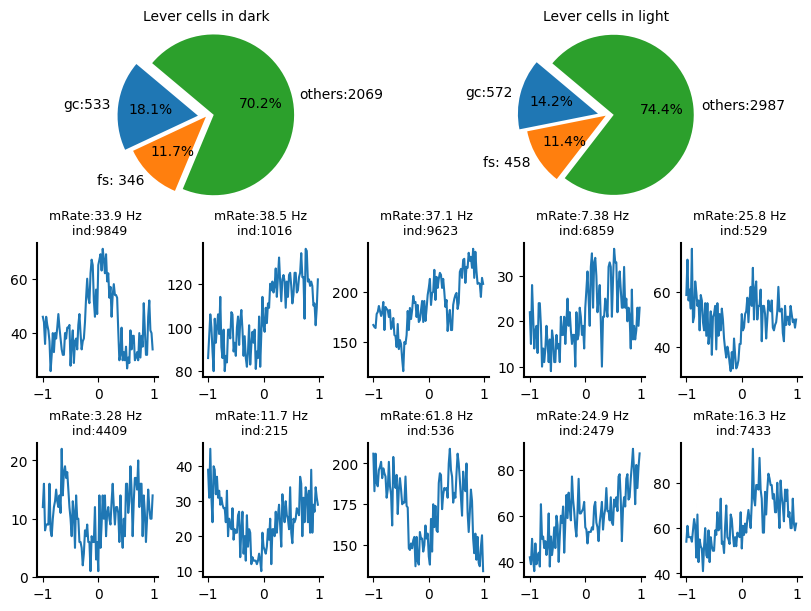

In [37]:
rowSize, colSize = 2,2
col, row = 5, 3

fig = plt.figure(figsize=(col * colSize, row * rowSize), constrained_layout=True)  # create a figure
gs = fig.add_gridspec(ncols=col, nrows=row, hspace=0.2, height_ratios=[1, 1, 1])  # create a GridSpec object to a figure

### dark
gsd= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[0,:2])
plot_levercellPercentage(gsd,lcdInd, gcleverDInd,FSleverDInd, OthleverDInd, title= 'Lever cells in dark')

## light
gsl= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[0,2:4])
plot_levercellPercentage(gsl,lclInd, gcleverLInd,FSleverLInd, OthleverLInd, title= 'Lever cells in light')

### gsexm
cells_to_plotind= [9849, 1016, 9623, 6859, 529, 4409, 215, 536, 2479, 7433]
gsexm= gridspec.GridSpecFromSubplotSpec(2,5,subplot_spec= gs[1:3,:4])
get_crosscorr_plot(gsexm, cells_to_plotind, timeStack )

## Detect the peak for the crosscorr of the cells

 we will smooth the data and detect a peak then find out if they were pressing before zero or after the zero 

In [38]:
import math 

def detect_peak(f, signal, peak_height='90%_max', peak_distance='0.1sec', sigma=1.5, binSize_sec= 0.02):
    """
        Method to find the peak frequency and calculate some 
        
        Arguments:
        f: time
        peak_height: required height for the peak to be detected
        peak_distance: required distance between detected peaks
        sigma: Gaussian kernel to smooth the signal before detecting the peak
        
        Return:
        theta peak frequency (in Hz), power at peak frequency, theta power, width at full height, width at half height 
    """
    
    from scipy.signal import find_peaks, peak_widths, peak_prominences
    from scipy import integrate
    from scipy.ndimage import gaussian_filter1d 
    
    if sigma:
        signal = gaussian_filter1d(signal, sigma=sigma)
    
    if peak_height == '90%_max':
        peak_height = np.max(signal)*0.9
    if peak_distance == '0.1sec':
        peak_distance = len(f)/20
    
    # detect the  peak
    peak = find_peaks(signal, height=peak_height, distance=peak_distance)
    
    # get the highest peak 
    if peak[0].size>0:
        #print('hi')
        # select peak with highest power if several have been found
        if len(peak[0])>1:
            #print('really?')
            #print('found more than 1 peak')
            max_power = np.nanmax([int(peak[1].get('peak_heights')[i]) for i,j in enumerate(peak[0])])
            peak_index_list = list(np.where([int(peak[1].get('peak_heights')[i]) for i,j in enumerate(peak[0])]==max_power))
            if len(peak_index_list[0])>1:
                peak_index_list[0] = peak_index_list[0][1:]
            peak_index = peak_index_list
            #print(peak[1].get('peak_heights'))
            #print(tuple(peak_index))
            peak_freq_sample = peak[0][tuple(peak_index)]
            peak_power = int(peak[1].get('peak_heights')[tuple(peak_index)][0])
            

        else:
            peak_freq_sample = peak[0]
            peak_power = int(peak[1].get('peak_heights'))
        peak_freq_sample=peak_freq_sample[0]  
    else:
        peak_freq_sample, peak_power=np.nan,np.nan
                
    res= (binSize_sec*peak_freq_sample)-1 ## only get the first peak 

    return res, peak_power

In [39]:
def plot_peak_croscorr(gs, timeStack, histStack, lcdInd, ct='dark', binSize_sec= 0.02):
    
    PeakTimesandPower=[detect_peak(timeStack[ind], histStack[ind], binSize_sec= binSize_sec) for i, ind in enumerate(lcdInd[:]) ]
    ## get rid of nans to for the histogram
    PeakTimes = [t for t in PeakTimesandPower if not any(isinstance(n, float) and math.isnan(n) for n in t)] ### to get rid of []
    times= [p[0] for i,p in enumerate(PeakTimes)]
    peaks=[p[1] for i,p in enumerate(PeakTimes)]
    
    ## ploting 
    ax=fig.add_subplot(gs[0])
    plt.hist(times, bins=20)
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('count')
    ax.set_title(f'{ct} ', fontsize= 10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
def plot_crosscor_celltype(gs,timeStack, histStack, lcdInd, lclInd, ct= 'Leverc'):
    '''
        plot the peak of the cross corrleation at the time of lever press for different cell types
    '''
    gsld= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[0,0])
    plot_peak_croscorr(gsld, timeStack, histStack, lcdInd, ct= f'{ct}_dark')

    gsll= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[0,1])
    plot_peak_croscorr(gsll, timeStack, histStack, lclInd, ct=f'{ct}_light')


In [40]:
# detect the  peak
peak = find_peaks(signal, height=peak_height, distance=peak_distance)

NameError: name 'signal' is not defined

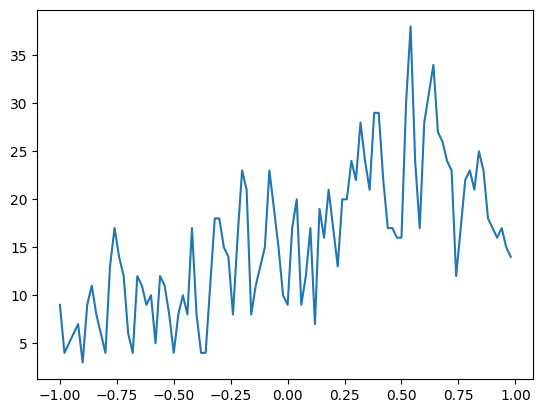

In [41]:
plt.plot(timeStack[11], histStack[11]) 

In [181]:
signal= histStack[11]
f= timeStack[11]
res1, power1= detect_peak(f, signal, peak_height='90%_max', peak_distance='0.1sec', sigma=1.5, binSize_sec= 0.05)

In [182]:
PeakTimesandPower= [detect_peak(timeStack[ind], histStack[ind],binSize_sec= 0.02) for i, ind in enumerate(lcdInd)]
times= [p[0] for i,p in enumerate(PeakTimesandPower)]
peaks= [p[1] for i,p in enumerate(PeakTimesandPower)]

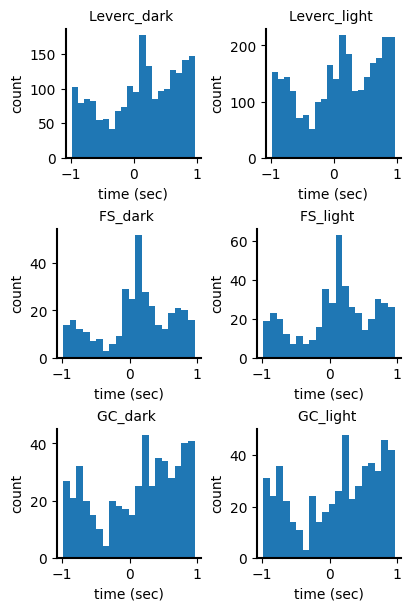

In [42]:
row=3
col=2

sizePerRow, sizePerCol = 2,2
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig, wspace=1) # all our figure

gslct= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,:])
plot_crosscor_celltype(gslct,timeStack, histStack, lcdInd, lclInd,  ct= 'Leverc')

gsfslct= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[1,:])
plot_crosscor_celltype(gsfslct,timeStack, histStack, FSleverDInd, FSleverLInd,  ct= 'FS')

gsfslct= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[2,:])
plot_crosscor_celltype(gsfslct,timeStack, histStack, gcleverDInd, gcleverLInd,  ct= 'GC')

## Calculate the peak of te firing rate in the lever ref frame and car ref frame for lever cells 

the length of the myLeverMapsDissociateStats is not the same as the cells df, the ineddx we have cant help us to detect the lever cells, thats why we select the maps in each reference frame and calculate the np.max of each dimenention to calculate the peak of the firing 

In [43]:
## filter the data only for lever cells

cluid_list = myLeverMaps['map']['all_light']['none']['cluid'].tolist()
len(levercLid), len(cluid_list)
indicesL = [index for index, value in enumerate(cluid_list) if value in levercLid]
indicesD = [index for index, value in enumerate(cluid_list) if value in levercDid]

llmaps= [ myLeverMaps['map']['all_light']['none']['data'][i] for i in indicesL]
ldmaps = [ myLeverMaps['map']['all_dark']['none']['data'][i] for i in indicesD]

rflmaps= [ myLeverMaps['map']['all_light']['arenaref']['data'][i] for i in indicesL]
rfdmaps = [ myLeverMaps['map']['all_dark']['arenaref']['data'][i] for i in indicesD]

In [44]:
## get ride of the nans 
for m in llmaps: 
    m = m[:, ~np.isnan(m).all(axis=0)]
    m = m[~np.isnan(m).all(axis=1), :]
    
for m in ldmaps: 
    m = m[:, ~np.isnan(m).all(axis=0)]
    m = m[~np.isnan(m).all(axis=1), :]
    
for m in rflmaps: 
    m = m[:, ~np.isnan(m).all(axis=0)]
    m = m[~np.isnan(m).all(axis=1), :]
    
for m in rfdmaps: 
    m = m[:, ~np.isnan(m).all(axis=0)]
    m = m[~np.isnan(m).all(axis=1), :]

In [45]:
# Calculate np.round(np.nanmax(im), 2) for each item in the filtered_data
PeakRatelcllrf = [ np.round(np.nanmax(item), 2) for item in llmaps]
PeakRatelcdlrf = [ np.round(np.nanmax(item), 2) for item in ldmaps]

## arena ref frame 
PeakRatelclrrf = [ np.round(np.nanmax(item), 2) for item in rflmaps]
PeakRatelcdrrf = [ np.round(np.nanmax(item), 2) for item in rfdmaps]

In [46]:
len(PeakRatelcllrf), len(PeakRatelcdlrf), len(PeakRatelclrrf), len(PeakRatelcdrrf)

(2987, 2069, 2987, 2069)

## get the peak rate for the lc in light or dark and per mouse 

In [47]:
from statannotations.Annotator import Annotator
deg_per_bin=10

Peakrd= pd.DataFrame({'PeakRateleverFrame_dark' : PeakRatelcdlrf,
                                'PeakRateCarFrame_dark' : PeakRatelcdrrf,
                                'cluid': levercDid })

Peakrl= pd.DataFrame({'PeakRateleverFrame_light' : PeakRatelcllrf,
                                'PeakRateCarFrame_light' : PeakRatelclrrf,
                                'cluid': levercLid })


In [48]:
Peakrdl= pd.DataFrame({'prate' : PeakRatelcdlrf,
                                'rf' : 'lrf',
                                'light': 'dark',
                                'cluid': levercDid })

Peakrll= pd.DataFrame({'prate' : PeakRatelcllrf,
                                'rf' : 'lrf',
                                'light': 'light',
                                'cluid': levercLid })

Peakrdr= pd.DataFrame({'prate' : PeakRatelcdrrf,
                                'rf' : 'rrf',
                                'light': 'dark',
                                'cluid': levercDid })

Peakrlr= pd.DataFrame({'prate' : PeakRatelclrrf,
                                'rf' : 'rrf',
                                'light': 'light',
                                'cluid': levercLid })
df= pd.concat([Peakrdl, Peakrll, Peakrdr, Peakrlr])

df['mice']= [cl.split('-')[0] for cl in df.cluid]
mdf= df.groupby(['mice', 'rf', 'light']).median().reset_index()
mdf

mdf['condition'] = np.nan
for index, row in mdf.iterrows():
    if row['light'] == 'light' and row['rf'] == 'lrf':
        mdf.loc[index, 'condition'] = 'lrfl'
    elif row['light'] == 'light' and row['rf'] == 'rrf':
        mdf.loc[index, 'condition'] = 'rrfl'
    elif row['light'] == 'dark' and row['rf'] == 'rrf':
        mdf.loc[index, 'condition'] = 'rrfd'
    elif row['light'] == 'dark' and row['rf'] == 'lrf':
        mdf.loc[index, 'condition'] = 'lrfd'


/tmp/ipykernel_722039/4196591331.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mdf= df.groupby(['mice', 'rf', 'light']).median().reset_index()


In [49]:
mdf.condition.unique()

mdf

,mice,rf,light,prate,condition
0,jp1084,lrf,dark,15.330,lrfd
1,jp1084,lrf,light,17.990,lrfl
2,jp1084,rrf,dark,14.760,rrfd
3,jp1084,rrf,light,18.420,rrfl
4,jp1684,lrf,dark,16.015,lrfd
...,...,...,...,...,...
63,mn8578,rrf,light,18.320,rrfl
64,mn8599,lrf,dark,15.660,lrfd
65,mn8599,lrf,light,17.360,lrfl
66,mn8599,rrf,dark,12.975,rrfd


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lrfd vs. lrfl: Wilcoxon test (paired samples), P_val:3.845e-03 Stat=1.800e+01
lrfl vs. rrfd: Wilcoxon test (paired samples), P_val:3.052e-05 Stat=1.000e+00
lrfd vs. rrfd: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
lrfl vs. rrfl: Wilcoxon test (paired samples), P_val:2.899e-04 Stat=7.000e+00
lrfd vs. rrfd: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
lrfd vs. rrfl: Wilcoxon test (paired samples), P_val:7.968e-02 Stat=3.900e+01


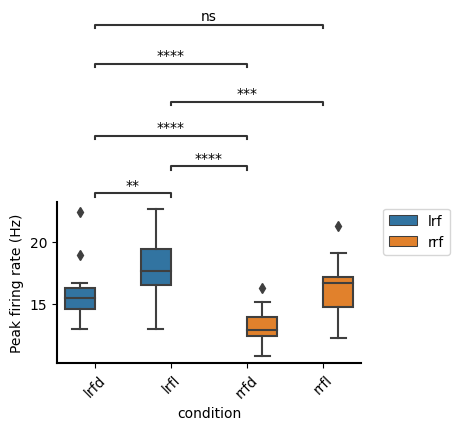

In [50]:
row=1
col=2

sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0, width_ratios=[0.5,1]) # all our figure

ax= fig.add_subplot(gs[1])
order= ['lrfd', 'lrfl', 'rrfd', 'rrfl']
b= sns.boxplot(data=mdf, x="condition", y="prate", hue="rf")
ax.set_xticklabels( order, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.set_ylabel('Peak firing rate (Hz)', fontsize= 10)
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

pairs = [("lrfd", "lrfl"), 
         ("lrfd", "rrfd"), 
         ("lrfd", "rrfl"),
         ("lrfl", "rrfl"), 
         ("lrfd", 'rrfd'), 
        ("lrfl", 'rrfd')]

annot = Annotator(b, pairs, data=mdf, x="condition", y="prate", order=order)
annot.configure(test='Wilcoxon', text_format='star', loc='outside', verbose=2)  # wilcoxon #Mann-Whitney
annot.apply_test()
ax, test_results = annot.annotate()

In [51]:
# Define the colors for the plots
hue_colors_hist = {'fs': 'red', 'gc': 'blue'}  # Red for fs, blue for gc
hue_colors_box = {'dark': '#004c99', 'light': '#ffaa00'}  # Dark blue for light, dark yellow for dark in boxplot

def plot_peakerate(gs,mdf): 
    ax= fig.add_subplot(gs[0])
    labs=['leverrf', 'roomrf']
    order= ['lrfd', 'lrfl', 'rrfd', 'rrfl']

    b= sns.boxplot(data=mdf,  x= 'rf', y = 'prate',hue= 'light', dodge=True, showfliers=False, palette=hue_colors_box)
    ax.set_xticklabels( labs, rotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.set_ylabel(' Peak firing rate (Hz)', fontsize= 10)
    ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
    pairs = [("lrfd", "rrfd"), ("lrfl", "rrfl")]

    
def plot_distribution_Prate(gs, PeakRatelcdlrf,PeakRatelcdrrf, PeakRatelcllrf,PeakRatelclrrf ):
    idenline = max(max(PeakRatelcdlrf), max(PeakRatelcdrrf))

    ax= fig.add_subplot(gs[0])
    ax.scatter(PeakRatelcdlrf, PeakRatelcdrrf, picker=True, s= 2)
    ax.plot([0,idenline],[0,idenline],'black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.grid(False)
    ax.set_ylabel('Peakrate in Card ref frame', fontsize= 10)
    ax.set_xlabel('PeakRate in Lever ref frame', fontsize= 10)
    ax.set_title(' dark', fontsize= 10)


    ax= fig.add_subplot(gs[1])
    idenline = max(max(PeakRatelcllrf), max(PeakRatelclrrf))

    ax.scatter(PeakRatelcllrf, PeakRatelclrrf, picker=True, s= 2)
    ax.plot([0,idenline],[0,idenline],'black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.grid(False)
    ax.set_ylabel('Peakrate in Card ref frame', fontsize= 10)
    ax.set_xlabel('PeakRate in Lever ref frame', fontsize= 10)
    ax.set_title(' Light', fontsize= 10)


## Peak rate in lfr vs carrf

This is a wrong plot as I am comparing the arena reference frame which is actually the light or dark conditions and compare that with te lever reference frame which is the lever centered map but not the lever rotated map 

The correct version of this plot is in the notebook : ’/lever_press/LeverDistance_lffMaps_3.ipynb’

Please correct this plot 

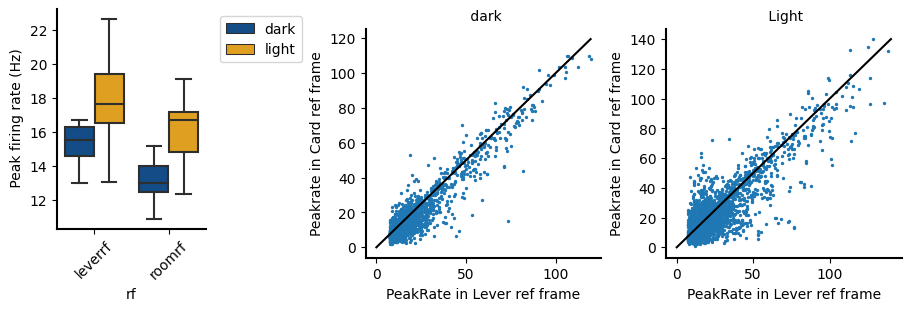

In [52]:
row=2
col=3

sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0 ) # all our figure

gsprate= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[0,0])
plot_peakerate(gsprate,mdf)

gsscatter= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,1:])
plot_distribution_Prate(gsscatter, PeakRatelcdlrf,PeakRatelcdrrf, PeakRatelcllrf,PeakRatelclrrf )

## Get the mean vector length

In [53]:
fn=myProject.dataPath+"/results/myLeverMapsDissociateStats_180.pickle"
with open(fn, 'rb') as handle:
    myLeverMapsDissociateStats = pickle.load(handle)


In [54]:
myLeverMapsDissociateStats.keys() , type(myLeverMapsDissociateStats['angular'])
myLeverMapsDissociateStats['angular'].keys() , type(myLeverMapsDissociateStats['angular']['all_light'])
myLeverMapsDissociateStats['angular']['all_light'].keys() , myLeverMapsDissociateStats['angular']['all_light']['lever'].shape , myLeverMapsDissociateStats['angular']['all_light']['none'].shape

(dict_keys(['lever', 'bridge', 'none']), (10850, 5), (10850, 5))

In [55]:
print(myLeverMapsDissociateStats.keys())
print(myLeverMapsDissociateStats["angular"].keys())
print(myLeverMapsDissociateStats["angular"]["all_light"].keys())
print(myLeverMapsDissociateStats["angular"]["all_light"]["lever"].shape)

dict_keys(['angular'])
dict_keys(['all_light', 'all_dark', 'all_light_1', 'all_light_2', 'all_dark_1', 'all_dark_2'])
dict_keys(['lever', 'bridge', 'none'])
(10850, 5)


In [56]:
LeverMapFrameL= myLeverMapsDissociateStats['angular']['all_light']['lever']
CarMapFrameL= myLeverMapsDissociateStats['angular']['all_light']['none']

LeverMapFrameD= myLeverMapsDissociateStats['angular']['all_dark']['lever']
CarMapFrameD= myLeverMapsDissociateStats['angular']['all_dark']['none']

LeverMVLl= [LeverMapFrameL[ind][2] for i, ind in enumerate(indicesL)]
CarMVLl = [CarMapFrameL[ind][2] for i, ind in enumerate(indicesL)]

LeverMVLd= [LeverMapFrameD[ind][2] for i, ind in enumerate(indicesD)]
CarMVLd = [CarMapFrameD[ind][2] for i, ind in enumerate(indicesD)]

mvll= pd.DataFrame({'LeverMVLl' : LeverMVLl,
                      'CarMVLl' : CarMVLl},
                                columns=['LeverMVLl','CarMVLl'])

mvld= pd.DataFrame({'LeverMVLd' : LeverMVLd,
                      'CarMVLd' : CarMVLd},
                                columns=['LeverMVLd','CarMVLd'])

mvldf= pd.concat([mvll,mvld], axis=1)

In [57]:
mvldf

,LeverMVLl,CarMVLl,LeverMVLd,CarMVLd
0,0.140213,0.317216,0.495114,0.563568
1,0.083500,0.108543,0.323917,0.485740
2,0.075067,0.143451,0.085380,0.095602
3,0.173029,0.381178,0.154324,0.160300
4,0.074531,0.066576,0.091105,0.090496
...,...,...,...,...
2982,0.162654,0.392367,NaN,NaN
2983,0.086289,0.291013,NaN,NaN
2984,0.108470,0.190015,NaN,NaN
2985,0.007132,0.030880,NaN,NaN


In [59]:
# Melt the dataframe to long format
melted_df = mvldf.melt(var_name='condition', value_name='MVL')

# Create 'light' and 'ref' columns based on 'condition'
melted_df['light'] = melted_df['condition'].apply(lambda x: 'light' if 'l' in x else 'dark')
melted_df['ref'] = melted_df['condition'].apply(lambda x: 'lever' if 'Lever' in x else 'card')

melted_df

,condition,MVL,light,ref
0,LeverMVLl,0.140213,light,lever
1,LeverMVLl,0.083500,light,lever
2,LeverMVLl,0.075067,light,lever
3,LeverMVLl,0.173029,light,lever
4,LeverMVLl,0.074531,light,lever
...,...,...,...,...
11943,CarMVLd,NaN,dark,card
11944,CarMVLd,NaN,dark,card
11945,CarMVLd,NaN,dark,card
11946,CarMVLd,NaN,dark,card


In [67]:
## just want to get the same color for light and dark as the other plots for presentation purpose :P

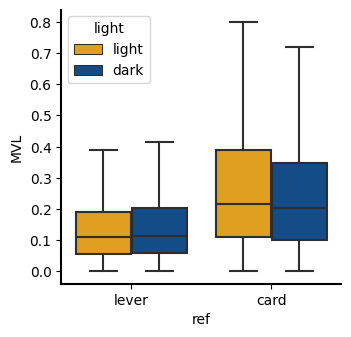

In [65]:
row=2
col=3

sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0.0 ) # all our figure

ax= fig.add_subplot(gs[0])
sns.boxplot(data=melted_df,  x= 'ref', y = 'MVL',hue= 'light', dodge=True, showfliers=False, palette=hue_colors_box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

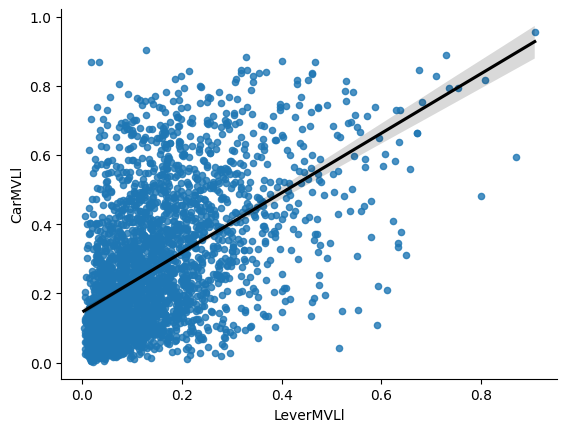

In [61]:
ax= sns.regplot(x="LeverMVLl", y="CarMVLl", data=mvll, line_kws={"color": "black"}, 
                 scatter_kws={"s": 20})

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



In [62]:
#pearsonr(mvld['LeverMVLd'].dropna(), mvld['CarMVLd'].dropna())
mvld['LeverMVLd'].shape, mvld['LeverMVLd'].fillna(0).shape, mvld['CarMVLd'].shape, mvld['CarMVLd'].dropna().shape

((2069,), (2069,), (2069,), (2069,))

In [200]:
def plot_mvl(gs, mvldf, mvll, mvld): 
    ax= fig.add_subplot(gs[0])
    labs= ['ll', 'carl', 'ld', 'card']
    sns.boxplot(data= mvldf,  dodge=True, showfliers=False)
    ax.set_xticklabels( labs, rotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.set_ylabel(' Mean vector length', fontsize= 10)
    pairs = [("LeverMVLl", "CarMVLl"), ("LeverMVLd", "CarMVLd")]
    
    ax= fig.add_subplot(gs[1])
    sns.regplot(x="LeverMVLl", y="CarMVLl", data=mvll, line_kws={"color": "black"}, scatter_kws={"s": 15})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    r, p = pearsonr(mvll['LeverMVLl'], mvll['CarMVLl'])
    ax.text(0.5,0.95, f"r:{r:.2f}")
    
    ax= fig.add_subplot(gs[2])
    sns.regplot(x="LeverMVLd", y="CarMVLd", data=mvld, line_kws={"color": "black"}, scatter_kws={"s": 15})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    r, p = pearsonr( mvld['LeverMVLd'].fillna(0), mvld['CarMVLd'])
    ax.text(0.5,0.95, f"r:{r:.2f}")

/home/maryam/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


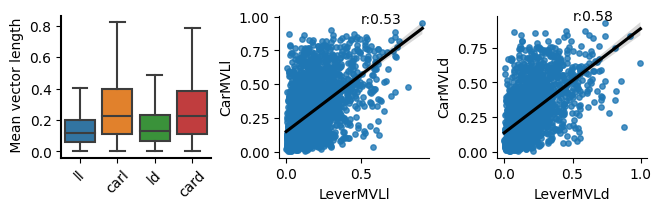

In [201]:
rowSize, colSize = 2,2
col, row = 4, 1

fig = plt.figure(figsize=(col * colSize, row * rowSize), constrained_layout=True)  # create a figure
gs = fig.add_gridspec(ncols=col, nrows=row )  # create a GridSpec object to a figure

plot_mvl(gs, mvldf, mvll, mvld)

## Get a figure for what we have at the moment 

/home/maryam/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


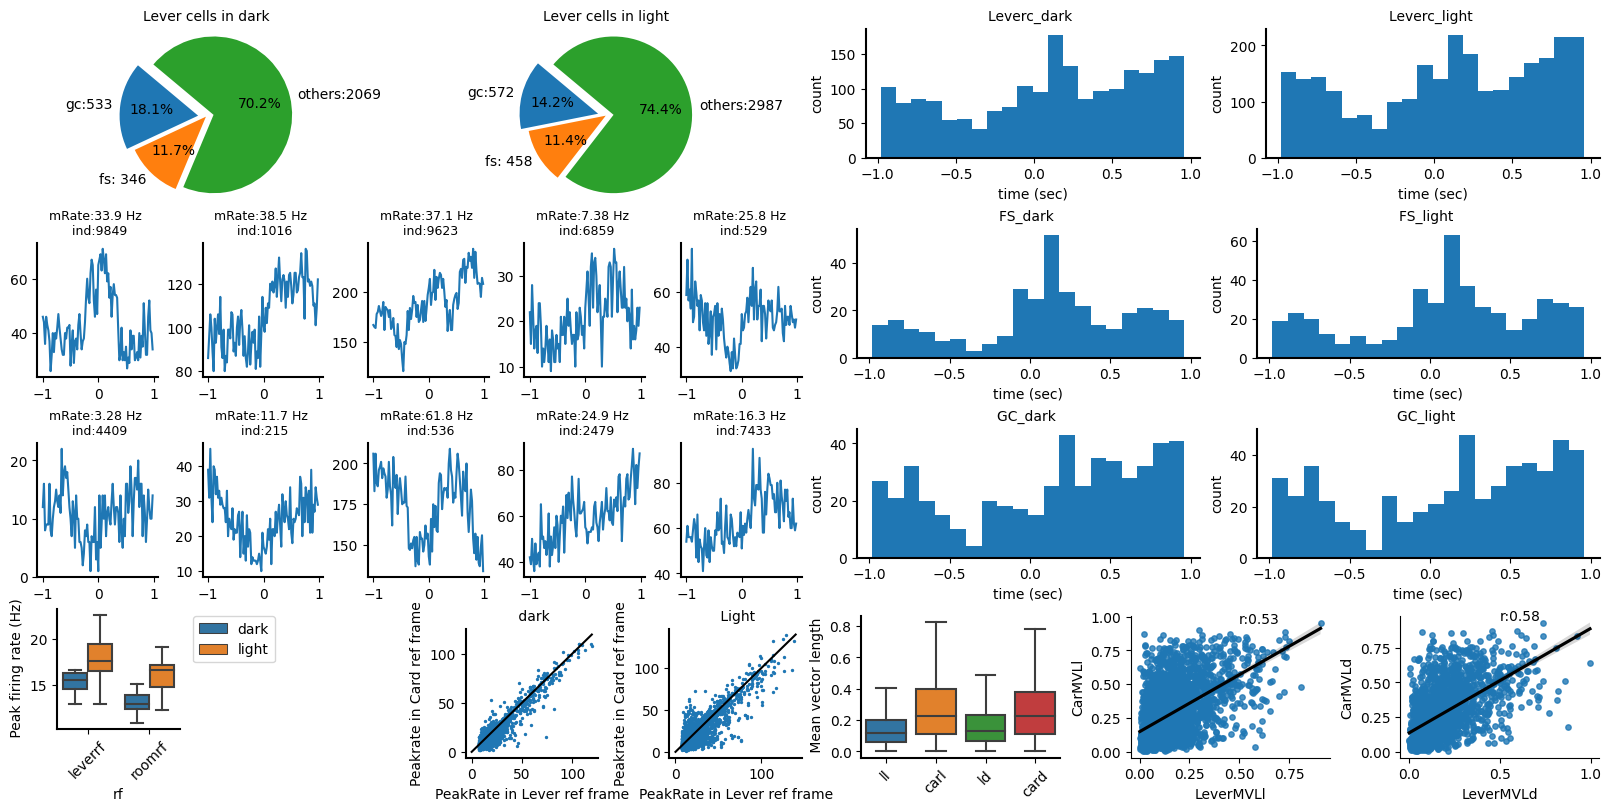

In [202]:
rowSize, colSize = 2,2
col, row = 8, 4

fig = plt.figure(figsize=(col * colSize, row * rowSize), constrained_layout=True)  # create a figure
gs = fig.add_gridspec(ncols=col, nrows=row, hspace=0.5, height_ratios=[1, 1, 1,1])  # create a GridSpec object to a figure

gsLetters = fig.add_gridspec(nrows=1, ncols=1,) # letters

### dark
gsd= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[0,:2])
plot_levercellPercentage(gsd,lcdInd, gcleverDInd,FSleverDInd, OthleverDInd, title= 'Lever cells in dark')

## light
gsl= gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[0,2:4])
plot_levercellPercentage(gsl,lclInd, gcleverLInd,FSleverLInd, OthleverLInd, title= 'Lever cells in light')
#ax=fig.gca() 
#ax.text(-10.4,1.8, 'a', style='normal',fontsize=13, weight="bold")
### gsexm
cells_to_plotind= [9849, 1016, 9623, 6859, 529, 4409, 215, 536, 2479, 7433]
gsexm= gridspec.GridSpecFromSubplotSpec(2,5,subplot_spec= gs[1:3,:4])
get_crosscorr_plot(gsexm, cells_to_plotind, timeStack )

##############
### Plot the time of the lever press in the
####################

gslct= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[0,4:])
plot_crosscor_celltype(gslct,timeStack, histStack, lcdInd, lclInd,  ct= 'Leverc')

gsfslct= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[1,4:])
plot_crosscor_celltype(gsfslct,timeStack, histStack, FSleverDInd, FSleverLInd,  ct= 'FS')

gsfslct= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[2,4:])
plot_crosscor_celltype(gsfslct,timeStack, histStack, gcleverDInd, gcleverLInd,  ct= 'GC')

##### Add the peakrate in different referebce frame 

gspr= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[3,:2])
plot_peakerate(gspr,mdf)

gsscatter= gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[3,2:4])
plot_distribution_Prate(gsscatter, PeakRatelcdlrf,PeakRatelcdrrf, PeakRatelcllrf,PeakRatelclrrf )

gsmvl= gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec= gs[3,4:])
plot_mvl(gsmvl, mvldf, mvll, mvld)

####

#ax.text(-10.5,-2, 'b', style='normal',fontsize=14, weight="bold")
#ax.text(0.0,0.20, 'c', style='normal',fontsize=10, weight="bold")
#ax.text(0.25,0.20, 'd', style='normal',fontsize=10, weight="bold")

#ax.text(0.45,0.90, 'e', style='normal',fontsize=10, weight="bold")
#ax.text(0.45,0.20, 'f', style='normal',fontsize=10, weight="bold")
#ax.text(1.5,1.8, 'c', style='normal',fontsize=14, weight="bold")
fn= 'mec_leverTime.pdf'
fig.savefig(fn, dpi= 300
           )

## plot some cells in the lever rf vs arena rf 

In [31]:
def plotmap(axes, cluId, maps, condition= 'circ80_1', showYLabel=True):
    mapindex=cells[cells.cluId==cluId].cluId
    #print(mapindex,mapindex.index)
    im=maps[condition][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='jet',interpolation=None)
    axes.set_title(f'{condition} \n {np.round(np.nanmax(im),2)} Hz',pad=3,y=0.99, fontsize=10)
    #axes.axis('off')
    #if showYLabel:
    #    axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

def plotLeverMap(axes, cluId, maps, df_HDInfoSingle, condition='all_light', r='none', showYLabel=True):
    nCells = maps["map"]["all_light"]["none"]['data'].shape[0]

    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break

    im = mapToPlot
    Lscore = df_HDInfoSingle[(df_HDInfoSingle.cluid == cluId) & (df_HDInfoSingle.light == condition)]['HD_score'].iloc[0]
    im = im[:, ~np.isnan(im).all(axis=0)]
    im = im[~np.isnan(im).all(axis=1), :]
    axes.imshow(im.T, origin="lower", cmap='jet', interpolation=None)
    
    if condition == 'all_light':
        condname = 'light'
    elif condition == 'all_dark':
        condname = 'dark'
        
    if r == 'none':
        rname = 'lever'
    else:
        rname = 'arenaref'
    
    if r=='none':
        
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz\nDirecS.-score: {Lscore:.2f}\n{condname} - {rname}', fontsize=9)
    else:
        axes.set_title(f'Pk rate: {np.round(np.nanmax(im),2)} Hz \n{condname} - {rname}', fontsize=10)
    axes.axis('off')
    
def plot_multiple_lever_maps(gs, cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs, colSize=1.8, rowSize=1.8):
    for i, condition in enumerate(conditions):
        for j, r in enumerate(rs):
            ax = fig.add_subplot(gs[0, i*len(rs) + j])
            plotLeverMap(ax, cellIdToPlot, myLeverMaps, df_HDInfoSingle, condition=condition, r=r)

            

In [32]:
LCdarkid= list(df_HDInfoSingle[(df_HDInfoSingle.light == 'all_dark') & 
                               df_HDInfoSingle.cluid.isin(levercDid) ][['HD_score','cluid']].sort_values('HD_score', ascending=False).cluid)

LClightid= list(df_HDInfoSingle[(df_HDInfoSingle.light == 'all_light') & 
                               df_HDInfoSingle.cluid.isin(levercLid) ][['HD_score','cluid']].sort_values('HD_score', ascending=False).cluid)


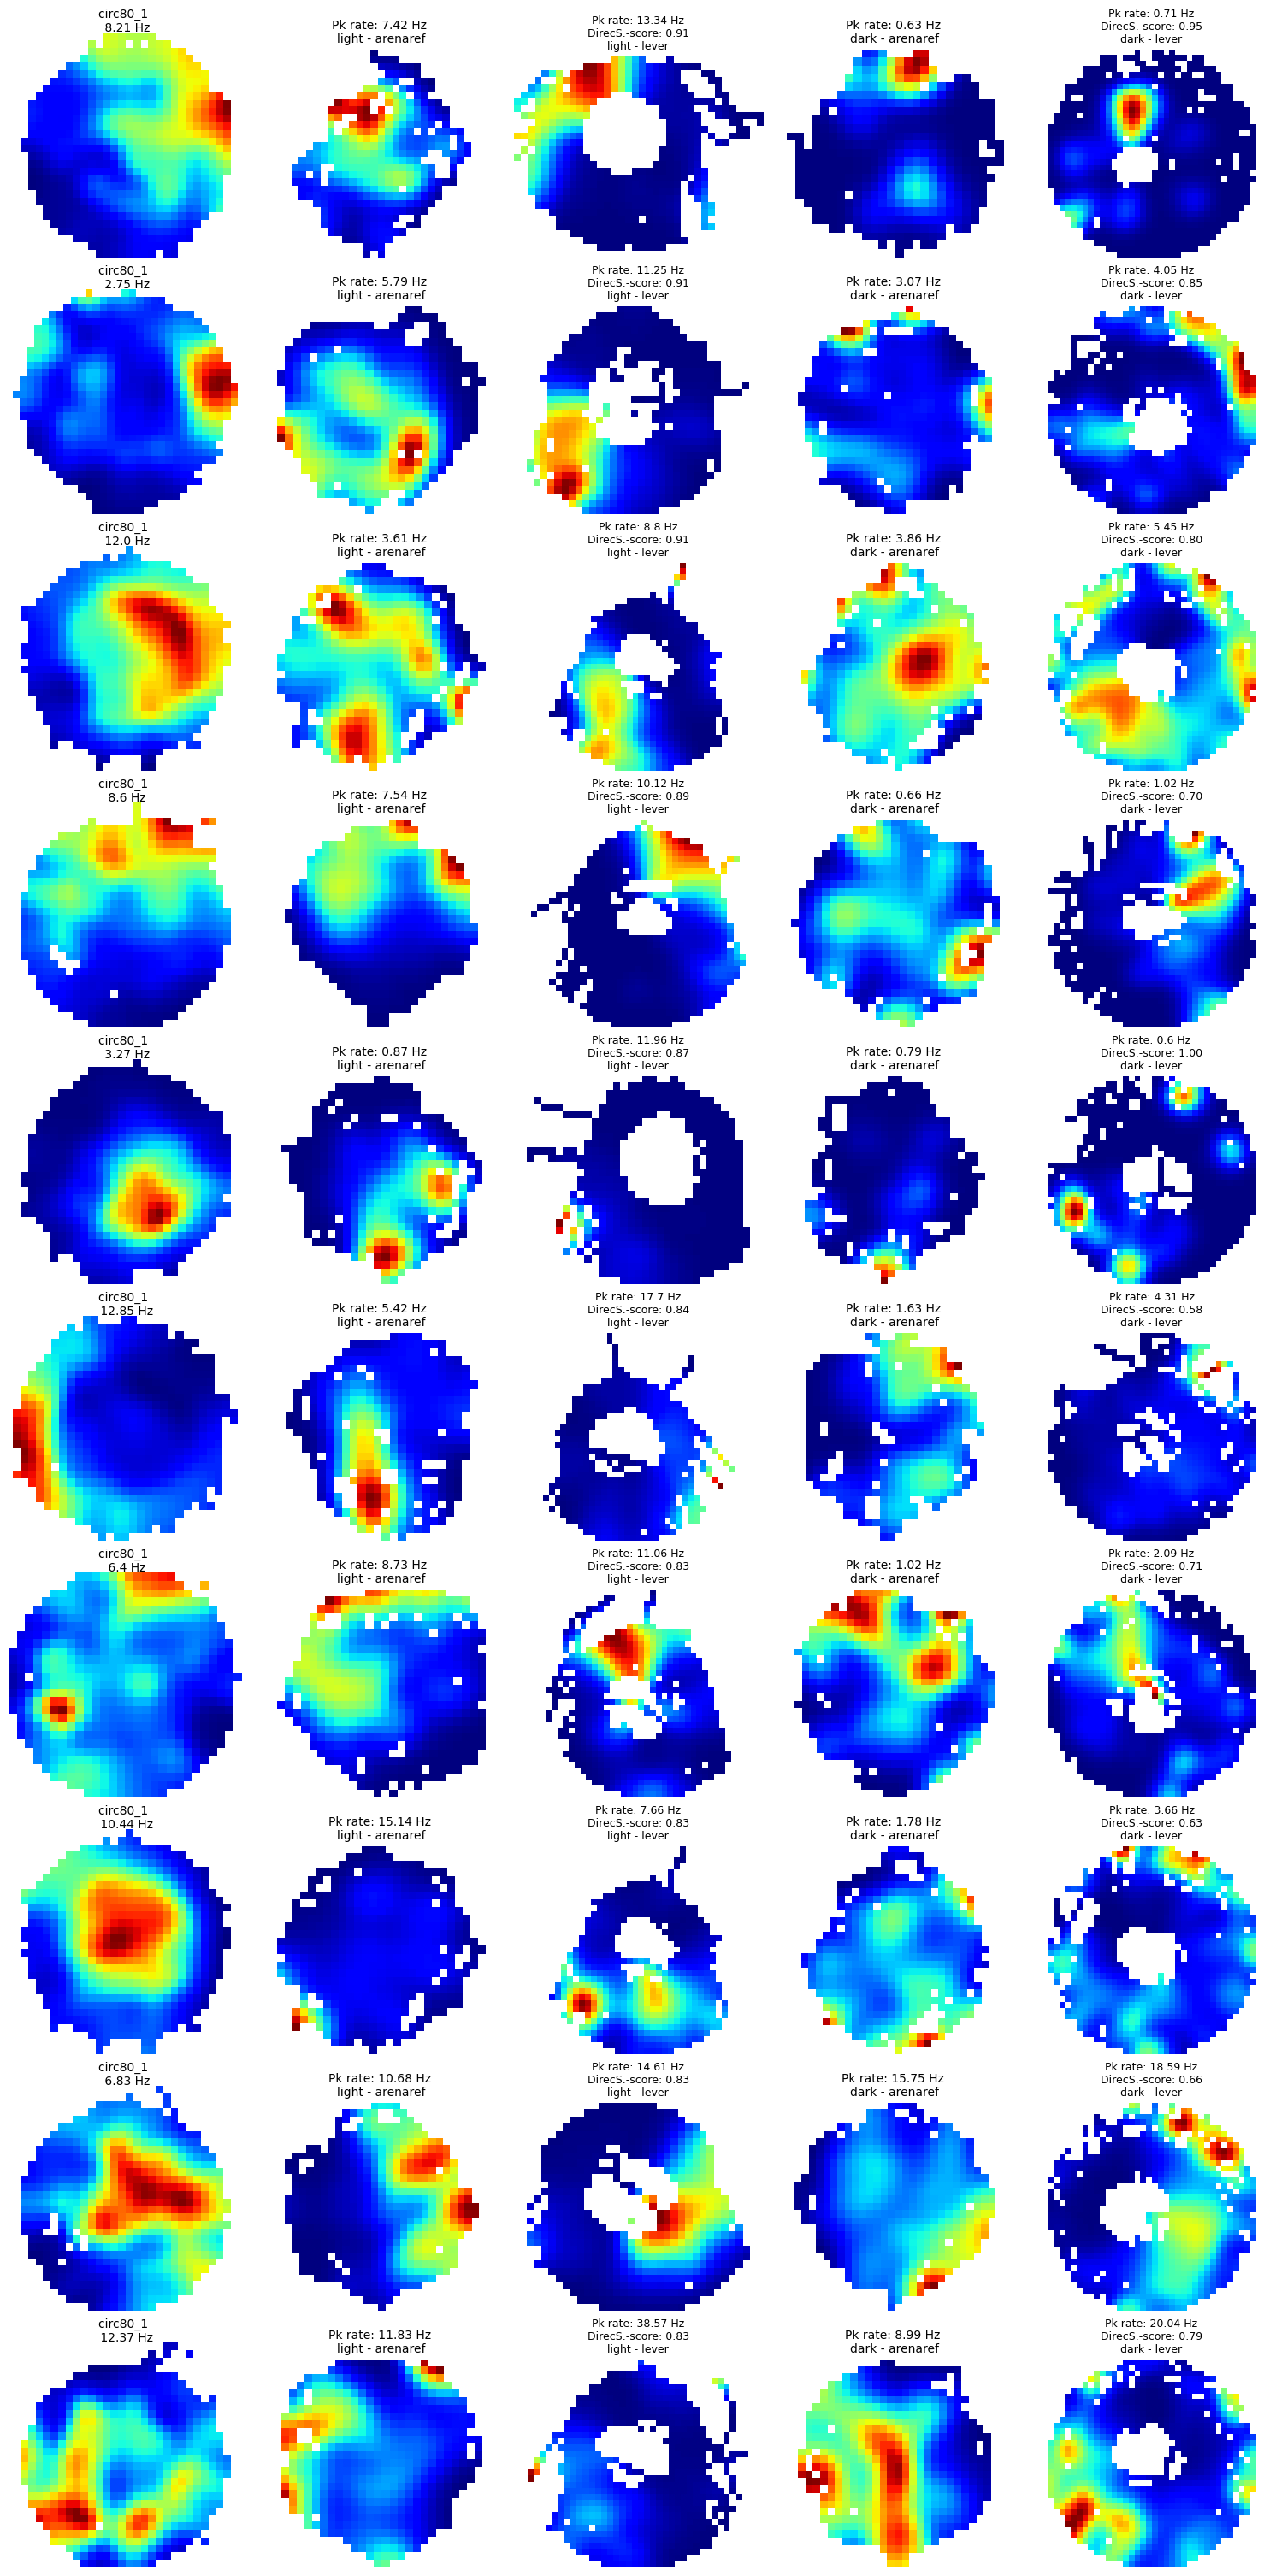

In [34]:
cellIdToPlots= LClightid[:10]

conditions = ['all_light', 'all_dark']
rs = ['arenaref', 'none']

nrows = len(cellIdToPlots)
ncols = 6

rowSize, colSize = 3, 3
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

for i, cellIdToPlot in enumerate(cellIdToPlots):
    gsOpenfiled = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[i,:1])
    axes= fig.add_subplot(gsOpenfiled[0])
    plotmap(axes, cellIdToPlot, myMaps, condition= 'circ80_1', showYLabel=True)

    gscell = gridspec.GridSpecFromSubplotSpec(1,4,subplot_spec= gs[i,1:5])
    plot_multiple_lever_maps(gscell,cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs)

fn= 'levecells_light.png'
fig.savefig(fn, dpi= 300)

plot some lever cells in dark 

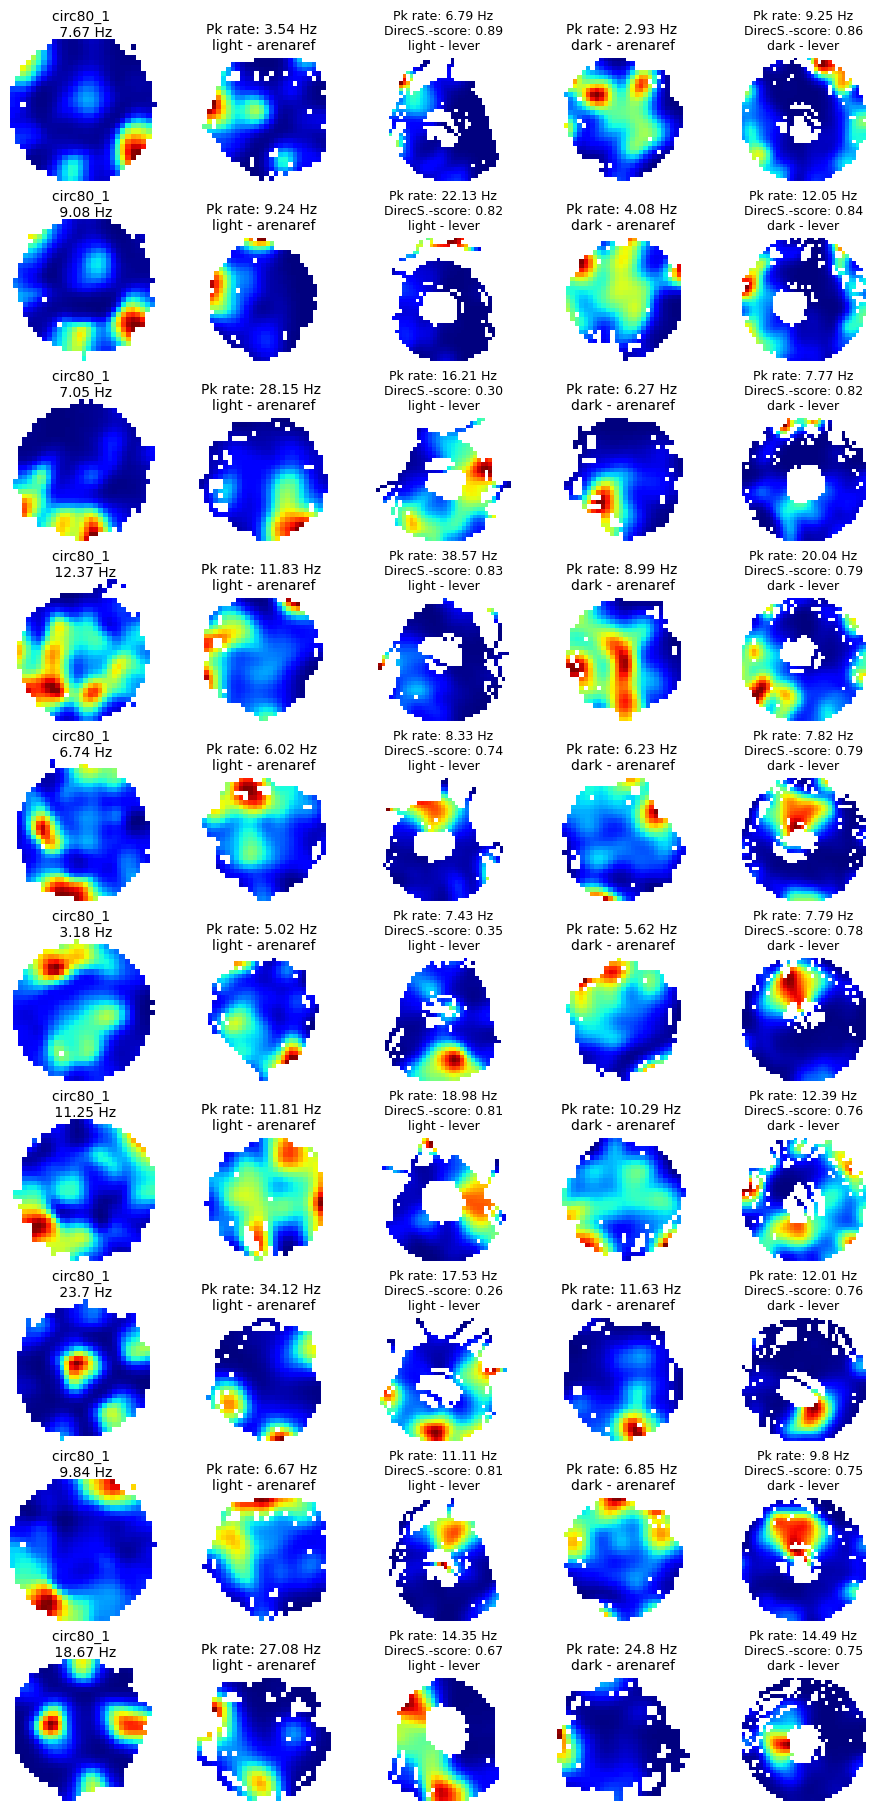

In [271]:
cellIdToPlots= LCdarkid[:10]

conditions = ['all_light', 'all_dark']
rs = ['arenaref', 'none']

nrows = len(cellIdToPlots)
ncols = 6

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig)

for i, cellIdToPlot in enumerate(cellIdToPlots):
    gsOpenfiled = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[i,:1])
    axes= fig.add_subplot(gsOpenfiled[0])
    plotmap(axes, cellIdToPlot, myMaps, condition= 'circ80_1', showYLabel=True)

    gscell = gridspec.GridSpecFromSubplotSpec(1,4,subplot_spec= gs[i,1:5])
    plot_multiple_lever_maps(gscell,cellIdToPlot, myLeverMaps, df_HDInfoSingle, conditions, rs)

fn= 'levecells_dark.png'
fig.savefig(fn, dpi= 300)

## find the index of the cells that fire after pressing the lever then plot:

1. We first find the max of the the first two peaks of the histogram 
2. Find the value and the index of the cells where they were firing after the lever press 
3. Plot the distribution of the position of the animal where they were firing 
5. Plot the 2D firing rate map of the cells in the lever rf but relative to lever orientation 
6. Check if these cells exists across mice or is there any differences accross animals 


In [227]:
## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)


loading behavior_180_v2.csv


In [228]:
PeakTimesandPower=[detect_peak(timeStack[ind], histStack[ind], binSize_sec= 0.02) for i, ind in enumerate(lclInd[:]) ]
PeakTimes = [t for t in PeakTimesandPower if not any(isinstance(n, float) and math.isnan(n) for n in t)] ### to get rid of []
times= [p[0] for i,p in enumerate(PeakTimes)]
peaks=[p[1] for i,p in enumerate(PeakTimes)]

len(peaks), len(times)

(2826, 2826)

In [229]:
# Sort the peaks by their values in descending order and get the first two
sortInd = np.argsort(peaks)[::-1][:2]

# Extract the first two peaks and their corresponding times and indices
p1ind= sortInd[0]
p2ind = sortInd[1]

time1 = times[p1ind]
time2 = times[p2ind]


In [230]:
time1, time2

(0.10000000000000009, 0.1200000000000001)

In [232]:
sSes= sSessions[136]
ses= myProject.sessionList[136]
LeverPressinRestime= res[res.sessionName== sSes.name].levertimeRes.values
    
#LeverPressinRestime


For each lever press get the time one sec before and after the lever press and plot 2d map

In [ ]:
for i, n in enumerate(sSes.cg.neuron_list):
    rate= n.spike_train.mean_firing_rate()
    hist,ran= n.spike_train.spike_time_crosscorrelation(st1= LeverPressinRestime, st2=n.spike_train.st , 
                                                        bin_size_sec= bin_size_sec , min_sec= min_sec , max_sec=max_sec )

## Get the location of the firing 

Get peak rate location for each neuron in light; this is similar to what was done in Ca1 fig5, distance to the lever center 

get the lever cells indices for light and dark and calculate the peak rate for them 


In [86]:
fn = myProject.dataPath+"/results/myLeverHistos.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myLeverHistos = pickle.load(handle)

for k in myLeverHistos[0].keys():
    for i in [0,1]:
        myLeverHistos[i][k]=myLeverHistos[i][k][[lclInd]] # rate arrays, occupancy arrays

for k in myLeverHistos[0].keys():
        myLeverHistos[3][k]=myLeverHistos[3][k][lclInd] # threshold for peak rate
    
peakLocl={}
peakHistoSignificancel={}
for cond in ["all_light"]:
    peakLocl[cond] = myLeverHistos[2][np.argmax(myLeverHistos[0][cond][0],axis=1)]
    peakHistoSignificancel[cond] = np.nanmax(myLeverHistos[0][cond][0],axis=1) > myLeverHistos[3][cond]
    
  #
dfpeaklockl=pd.DataFrame({'peakRateLight':peakLocl["all_light"],'cid':levercLid, 'light': 'light'})
dfpeaklockl['subject']= [cid.split('-')[0] for cid in dfpeaklockl.cid]
###########
## Group the df based on mouse
##########
dfml=dfpeaklockl.groupby(['subject']).median().reset_index()

#####################################
###  do the same thing for the level cells dark 
######################################
fn = myProject.dataPath+"/results/myLeverHistos.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myLeverHistos = pickle.load(handle)


for k in myLeverHistos[0].keys():
    for i in [0,1]:
        myLeverHistos[i][k]=myLeverHistos[i][k][[lcdInd]] # rate arrays, occupancy arrays

for k in myLeverHistos[0].keys():
        myLeverHistos[3][k]=myLeverHistos[3][k][lcdInd] # threshold for peak rate
    
peakLocd={}
peakHistoSignificanced={}
for cond in ["all_dark"]:
    peakLocd[cond] = myLeverHistos[2][np.argmax(myLeverHistos[0][cond][0],axis=1)]
    peakHistoSignificanced[cond] = np.nanmax(myLeverHistos[0][cond][0],axis=1) > myLeverHistos[3][cond]
    
dfpeaklockd=pd.DataFrame({'peakRateDark':peakLocd["all_dark"],'cid':levercDid, 'light': 'dark'})
dfpeaklockd['subject']= [cid.split('-')[0] for cid in dfpeaklockd.cid]



###########
## Group the df based on mouse
##########
dfmd=dfpeaklockd.groupby(['subject']).median().reset_index()

dfrate= dfmd.merge(dfml, how='left', on='subject')#


/tmp/ipykernel_3688035/2052958803.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfml=dfpeaklockl.groupby(['subject']).median().reset_index()
/tmp/ipykernel_3688035/2052958803.py:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfmd=dfpeaklockd.groupby(['subject']).median().reset_index()


In [75]:
dfmd['light']= 'dark'
dfml['light']= 'light'
dfml.rename(columns={'pr_distance': 'peakLoc'}, inplace=True)
dfmd.rename(columns={'pr_distance': 'peakLoc'}, inplace=True)

peakLocdf= pd.concat([dfmd, dfml])
peakLocdf= peakLocdf.reset_index(drop=True)

In [97]:
# Merge the DataFrames on 'cid'
final_df = pd.merge(dfpeaklockl, dfpeaklockd, on='cid', how='outer')

# Combine subject columns
final_df['subject'] = final_df['subject_x'].combine_first(final_df['subject_y'])

# Drop the now redundant subject columns
final_df = final_df.drop(columns=['subject_x', 'subject_y'])

final_df.rename(columns={'peakRateDark': 'peakLoc'}, inplace=True)
final_df['light'] = final_df['light_x'].combine_first(final_df['light_y'])

peakLoc= final_df.drop(columns=['light_x', 'light_y', 'peakRateLight'])

In [62]:
fn = myProject.dataPath+"/results/myLeverHistos.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myLeverHistos = pickle.load(handle)

# Convert lists to sets and take the union
lcset = set(lclInd).union(set(lcdInd))
lcInd = list(lcset)

for k in myLeverHistos[0].keys():
    for i in [0,1]:
        myLeverHistos[i][k]=myLeverHistos[i][k][[lcInd]] # rate arrays, occupancy arrays

for k in myLeverHistos[0].keys():
        myLeverHistos[3][k]=myLeverHistos[3][k][lcInd] # threshold for peak rate
    


/home/maryam/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


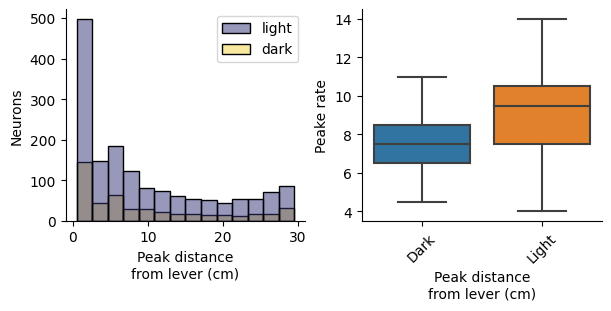

In [96]:
## standard plot config

col=2
row=1
sizePerRow, sizePerCol = 3,3
fig = plt.figure(figsize=(col*sizePerCol,row*sizePerRow),constrained_layout=True) 
gs = gridspec.GridSpec(1, 2, figure=fig) # all our figure

def peakDistributionPlot(gs):
    ax = fig.add_subplot(gs[0])
    #g = sns.histplot(x="peakLoc",hue="light",data=resLocDist,palette=darkLightColors(),ax=ax)
    g= sns.histplot(x="peakLoc",hue="light",data=peakLoc,palette=darkLightColors())
    g.legend_.set_title("")
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Peak distance\nfrom lever (cm)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = fig.add_subplot(gs[1])
    g = sns.boxplot(data= dfrate ,dodge=True, showfliers=False, ax= ax)
    labs= ['Dark', 'Light']
    ax.set_xticklabels( labs, rotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Peake rate")
    ax.set_xlabel("Peak distance\nfrom lever (cm)")

    

peakDistributionPlot(gs)

In [99]:
cells[cells.usable_auto_RF].shape

(5734, 41)

In [101]:
cells[cells.interneuron].shape, cells[(cells.interneuron) & (cells.mrate_RF1> 10)].shape, 

((838, 41), (582, 41))